# Chapter 5 - Resampling Methods

- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

## Part 1 - Cross Validation

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
#plt.style.use('seaborn-white')

### Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
df1 = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 5.1 Cross-Validation

### Figure 5.2 - Validation Set Approach
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

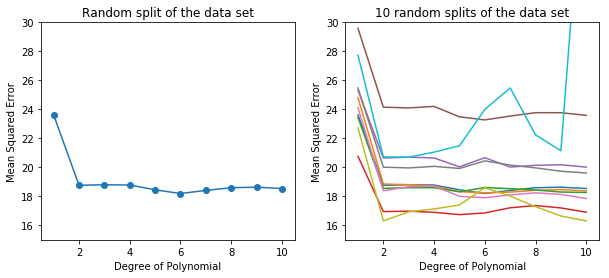

In [3]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset (10개 polynomial degree * 10 random splits = 100 iterations)
for (i,j),v in np.ndenumerate(Z):
    #print(i,j,v)
    #print("Fitting feature degree: ", int(X[i,j]))
    #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
    #1~10차까지 fitting. PolynomialFeatures(d)하면 horsepower를 d차원 다항식으로 feature뽑는 것. 지금은 predictor가 하나니까 x, x^2, x^3 ... 으로 전개
    #fit_transform 예시 https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/
    poly = PolynomialFeatures(int(X[i,j])) #1~10차까지 fitting.
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    #print(X_poly.shape)
    #mpg = miles per gallon
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                   
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

### Figure 5.4

In [4]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()
score_raw = np.zeros([10,392])

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    #score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error')
    score_raw[i-1,:] = score
    score = score.mean()
    scores.append(score)

In [5]:
# 10-fold CV
folds = 10

scores_10fold = list()
score_raw_10fold = np.zeros([10,folds])

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds)
    
    score_10fold = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error')
    score_raw_10fold[i-1,:] = score_10fold
    score_10fold = score_10fold.mean()
    scores_10fold.append(score_10fold)

In [6]:
# 5-fold CV
folds = 5

scores_5fold = list()
score_raw_5fold = np.zeros([10,folds])

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    kf_5 = KFold(n_splits=folds)
    
    score_5fold = cross_val_score(regr, X_poly, df1.mpg, cv=kf_5, scoring='neg_mean_squared_error')
    score_raw_5fold[i-1,:] = score_5fold
    score_5fold = score_5fold.mean()
    scores_5fold.append(score_5fold)

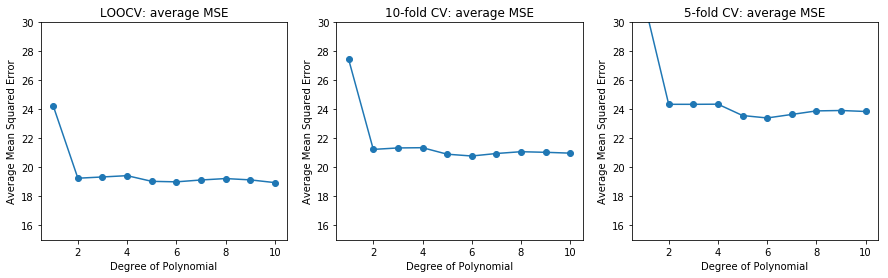

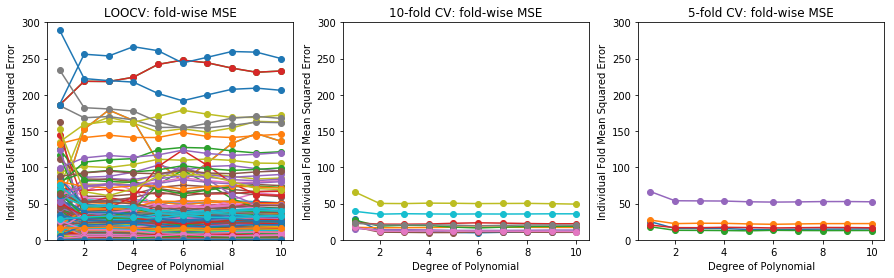

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV: average MSE')

# Right plot
ax2.plot(p_order,np.array(scores_10fold)*-1,'-o')
ax2.set_title('10-fold CV: average MSE')

# Right plot
ax3.plot(p_order,np.array(scores_5fold)*-1,'-o')
ax3.set_title('5-fold CV: average MSE')

for ax in fig.axes:
    ax.set_ylabel('Average Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));
plt.show()
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
for i in range(392):
    ax1.plot(p_order, score_raw[:,i]*-1,'-o')
    ax1.set_title('LOOCV: fold-wise MSE')
    
for i in range(10):
    ax2.plot(p_order, score_raw_10fold[:,i]*-1,'-o')
    ax2.set_title('10-fold CV: fold-wise MSE')
    
for i in range(5):
    ax3.plot(p_order, score_raw_5fold[:,i]*-1,'-o')
    ax3.set_title('5-fold CV: fold-wise MSE')
    
for ax in fig.axes:
    ax.set_ylabel('Individual Fold Mean Squared Error')
    ax.set_ylim(0,300)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));
plt.show()

## Part 2 - Bootstrap

We revisit the investment example in the lecture slides.

### Simulate 4 different dataset and estimate  $\alpha$

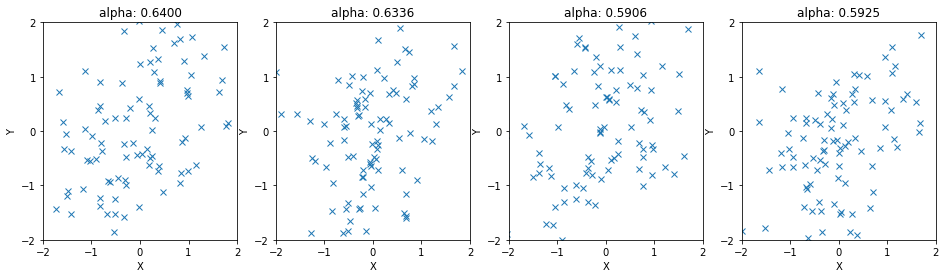

In [8]:
from sklearn.utils import resample

mean = [0, 0]
cov = [[1, 0.5], [0.5, 1.25]]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))
n_samples = 100

x, y = np.random.multivariate_normal(mean, cov, n_samples).T
std_x = np.std(x)
std_y = np.std(y)
a_hat = (std_y*std_y - np.cov(x,y)[0,1])/(std_x*std_x + std_y*std_y - 2*np.cov(x,y)[0,1])
# Left plot (first split)
ax1.plot(x,y, 'x')
title = 'alpha: %.4f'%a_hat
ax1.set_title(title)

x, y = np.random.multivariate_normal(mean, cov, n_samples).T
# Left plot (first split)
std_x = np.std(x)
std_y = np.std(y)
a_hat = (std_y*std_y - np.cov(x,y)[0,1])/(std_x*std_x + std_y*std_y - 2*np.cov(x,y)[0,1])
# Left plot (first split)
ax2.plot(x,y, 'x')
title = 'alpha: %.4f'%a_hat
ax2.set_title(title)

x, y = np.random.multivariate_normal(mean, cov, n_samples).T
std_x = np.std(x)
std_y = np.std(y)
a_hat = (std_y*std_y - np.cov(x,y)[0,1])/(std_x*std_x + std_y*std_y - 2*np.cov(x,y)[0,1])
# Left plot (first split)
ax3.plot(x,y, 'x')
title = 'alpha: %.4f'%a_hat
ax3.set_title(title)

x, y = np.random.multivariate_normal(mean, cov, n_samples).T
std_x = np.std(x)
std_y = np.std(y)
a_hat = (std_y*std_y - np.cov(x,y)[0,1])/(std_x*std_x + std_y*std_y - 2*np.cov(x,y)[0,1])
# Left plot (first split)
ax4.plot(x,y, 'x')
title = 'alpha: %.4f'%a_hat
ax4.set_title(title)

for ax in fig.axes:
    ax.set_ylabel('Y')
    ax.set_ylim(-2,2)
    ax.set_xlabel('X')
    ax.set_xlim(-2,2)
    ax.set_xticks(range(-2,3,1));
    ax.set_yticks(range(-2,3,1));

### Repeat the above process 1000 time and plot histograms of $\alpha$

Estimated alpha from 1000 simulated datasets: 0.6020 +- 0.0817


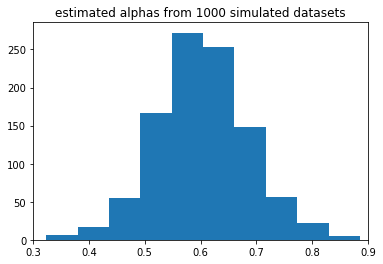

In [9]:
a_hat_list = []
for i in range(1000):
    x, y = np.random.multivariate_normal(mean, cov, n_samples).T
    std_x = np.std(x)
    std_y = np.std(y)
    a_hat = (std_y*std_y - np.cov(x,y)[0,1])/(std_x*std_x + std_y*std_y - 2*np.cov(x,y)[0,1])
    a_hat_list.append(a_hat)
a_hat_list = np.array(a_hat_list)
print("Estimated alpha from 1000 simulated datasets: %.4f +- %.4f" %(np.mean(a_hat_list), np.std(a_hat_list)))

plt.figure()
plt.hist(a_hat_list)
plt.title("estimated alphas from 1000 simulated datasets")
plt.xlim([0.3,0.9])
plt.show()

### Generate 1000 bootstrap datasets and estimate $\alpha$

Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: 0.6462 +- 0.0831


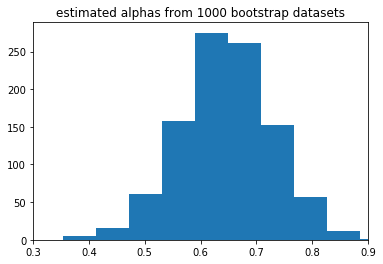

In [11]:
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
a_hat_list = []
for i in range(1000):
    x_hat, y_hat = resample(x,y,n_samples=n_samples)
    std_x = np.std(x_hat)
    std_y = np.std(y_hat)
    a_hat = (std_y*std_y - np.cov(x_hat,y_hat)[0,1])/(std_x*std_x + std_y*std_y 
                                                      - 2*np.cov(x_hat,y_hat)[0,1])
    a_hat_list.append(a_hat)
a_hat_list = np.array(a_hat_list)
print("Estimated alpha from 1000 bootstrap datasets from a single simulation dataset: %.4f +- %.4f" %(np.mean(a_hat_list), np.std(a_hat_list)))

plt.figure()
plt.hist(a_hat_list)
plt.title("estimated alphas from 1000 bootstrap datasets")
plt.xlim([0.3,0.9])
plt.show()